Inspiration and tigramite examples based on [this notebook](https://github.com/jakobrunge/tigramite/blob/master/tutorials/tigramite_tutorial_basics.ipynb).

In [14]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tigramite as ti
from tigramite import data_processing as ti_dp
from tigramite import plotting as ti_plt
from tigramite import independence_tests as ti_it
import tigramite.pcmci as to_pmci
import statsmodels.api as sm
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R 
library(dagitty)

In [3]:
%load_ext RWinOut

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


$$
\begin{align*}
X_{0,t} & = 0.7 X_{0,t-1} - 0.8 X_{1, t-1} + u_{0,t} \\
X_{1,t} & = 0.8 X_{1, t-1} + 0.8 X_{3, t-1} + u_{1,t} \\
X_{2,t} & = 0.5 X_{2,t-1} + 0.5 X_{1,t-2} + 0.6 X_{3,t-3} + u_{2,t} \\
X_{3,t} & = 0.7 X_{3,t-1} + u_{3,t}
\end{align*}
$$

$u_t$ are independent, zero-mean unit variace random variables.

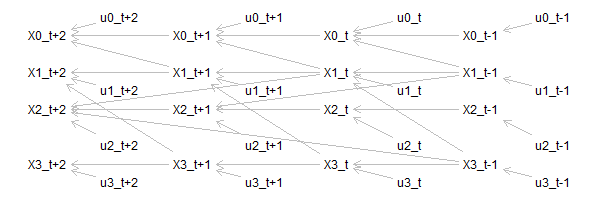

In [4]:
%%R -h 200 -w 600
g = dagitty( 'dag {
    "X0_t+2" [pos="0,1"]
    "X0_t+1" [pos="2,1"]
    "X0_t"   [pos="4,1"]
    "X0_t-1" [pos="6,1"]
    "X1_t+2" [pos="0,3"]
    "X1_t+1" [pos="2,3"]
    "X1_t"   [pos="4,3"]
    "X1_t-1" [pos="6,3"]
    "X2_t+2" [pos="0,5"]
    "X2_t+1" [pos="2,5"]
    "X2_t"   [pos="4,5"]
    "X2_t-1" [pos="6,5"]
    "X3_t+2" [pos="0,8"]
    "X3_t+1" [pos="2,8"]
    "X3_t"   [pos="4,8"]
    "X3_t-1" [pos="6,8"]
    "u0_t+2" [pos="1,0"]
    "u0_t+1" [pos="3,0"]
    "u0_t"   [pos="5,0"]
    "u0_t-1" [pos="7,0"]
    "u1_t+2" [pos="1,4"]
    "u1_t+1" [pos="3,4"]
    "u1_t"   [pos="5,4"]
    "u1_t-1" [pos="7,4"]
    "u2_t+2" [pos="1,7"]
    "u2_t+1" [pos="3,7"]
    "u2_t"   [pos="5,7"]
    "u2_t-1" [pos="7,7"]
    "u3_t+2" [pos="1,9"]
    "u3_t+1" [pos="3,9"]
    "u3_t"   [pos="5,9"]
    "u3_t-1" [pos="7,9"]
    "X0_t+2" <- "X0_t+1" <- "X0_t" <- "X0_t-1"
    "X1_t+2" <- "X1_t+1" <- "X1_t" <- "X1_t-1"
    "X2_t+2" <- "X2_t+1" <- "X2_t" <- "X2_t-1"
    "X3_t+2" <- "X3_t+1" <- "X3_t" <- "X3_t-1"
    "X0_t+2" <- "u0_t+2"; "X0_t+1" <- "u0_t+1"; "X0_t" <- "u0_t"; "X0_t-1" <- "u0_t-1"
    "X1_t+2" <- "u1_t+2"; "X1_t+1" <- "u1_t+1"; "X1_t" <- "u1_t"; "X1_t-1" <- "u1_t-1"
    "X2_t+2" <- "u2_t+2"; "X2_t+1" <- "u2_t+1"; "X2_t" <- "u2_t"; "X2_t-1" <- "u2_t-1"
    "X3_t+2" <- "u3_t+2"; "X3_t+1" <- "u3_t+1"; "X3_t" <- "u3_t"; "X3_t-1" <- "u3_t-1"

    "X0_t+2" <- "X1_t+1"; "X0_t+1" <- "X1_t"; "X0_t" <- "X1_t-1";
    "X1_t+2" <- "X3_t+1"; "X1_t+1" <- "X3_t"; "X1_t" <- "X3_t-1";
    "X2_t+2" <- "X1_t"; "X2_t+1" <- "X1_t-1";
    "X2_t+2" <- "X3_t-1";    

}')
plot(g)

In [5]:
# Simulate data according to GDP
np.random.seed(42)
var_names = [r'$X_0$', r'$X_1$', r'$X_2$', r'$X_3$']
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
T = 1000
data, true_parents_neighbors = ti_dp.var_process(links_coeffs, T=T)

df = pd.DataFrame(data, columns=var_names)
df_ti = ti_dp.DataFrame(data, datatime=np.arange(len(data)), var_names=var_names)

,$X_0$,$X_1$,$X_2$,$X_3$
0,0.496714,1.399355,-0.675178,-1.907808
1,-0.138264,0.924634,-0.144519,-0.860385


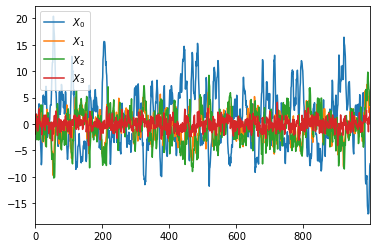

In [6]:
#ti_plt.plot_timeseries(df_ti)
display(df.head(2))
_ = df.plot()

## Fit "perfect" SVAR model

In [7]:
# VAR
model1_var = sm.tsa.VAR(df.copy())
res1_var = model1_var.fit(maxlags=3)
irf1_var = res1_var.irf(20)

# SVAR
D = np.asarray([
    ["E", 0, 0, 0],
    ["E", "E", 0, 0],
    ["E", "E", "E", 0],
    ["E", "E", "E", "E"],    
])
model1_svar = sm.tsa.SVAR(df.copy(), svar_type='A', A=D)
res1_svar = model1_svar.fit(maxlags=3)
irf1_svar = res1_svar.irf(20)

In [8]:
res1_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 10, Oct, 2020
Time:                     18:23:22
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.423404
Nobs:                     997.000    HQIC:                  0.264831
Log likelihood:          -5690.27    FPE:                    1.18246
AIC:                     0.167589    Det(Omega_mle):         1.12274
--------------------------------------------------------------------
Results for equation $X_0$
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.021925         0.033262            0.659           0.510
L1.$X_0$         0.681807         0.031802           21.439           0.000
L1.$X_1$        -0.872495         0.032380          -26.945           0.000
L1.$

In [9]:
display(pd.DataFrame(np.linalg.inv(res1_svar.A)))

,0,1,2,3
0,1.014438,0.000000,0.000000,0.000000
1,-0.052522,0.998253,0.000000,0.000000
2,0.007812,0.021555,1.015437,0.000000
3,0.010548,-0.051169,-0.008850,1.030437


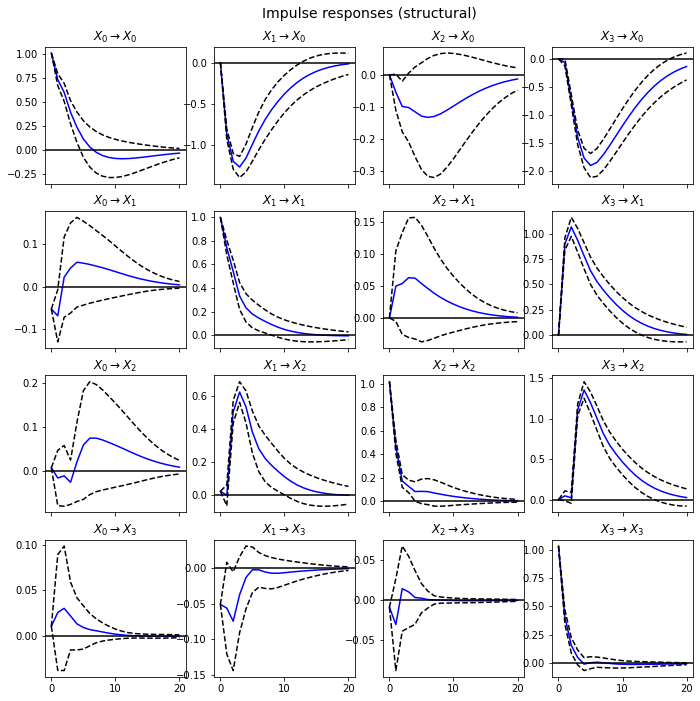

In [10]:
fig = irf1_svar.plot()

## PMCI with (linear) partial correlation as conditional independency test

In [15]:
parcorr = ti_it.ParCorr(significance='analytic')
pcmci = to_pmci.PCMCI(
    dataframe=df_ti, 
    cond_ind_test=parcorr,
    verbosity=1
)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


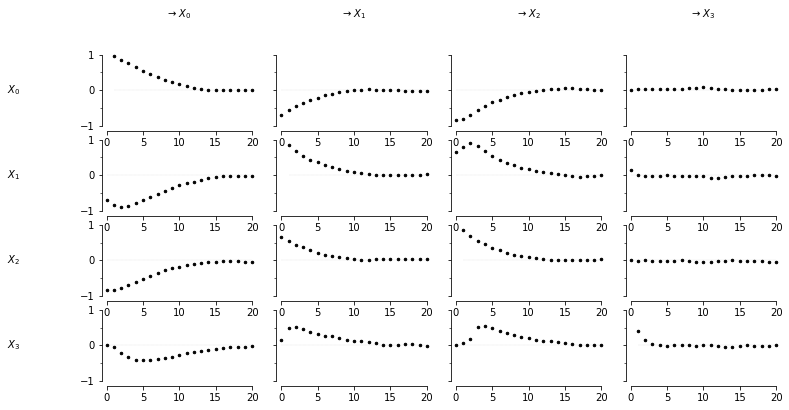

In [24]:
# Run unconditional lagged independence test
# Not sure what is does here: calculates simple correlations?
correlations = pcmci.get_lagged_dependencies(
    tau_max=20,
    val_only=True
)['val_matrix']

# Plot
lag_func_matrix = ti_plt.plot_lagfuncs(
    val_matrix=correlations,
    setup_args={
        'var_names':var_names, 
        'x_base':5,
        'y_base':1.0,
        'figsize':(12, 6)
    }
)

In [25]:
# Run PMCI algorithm. tau_max=8 is chosen based on the independence plot above:
# "Since the dependencies decay beyond a maximum lag of around 8, we choose tau_max=8 for PCMCI."
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X_0$ has 7 parent(s):
    [pc_alpha = 0.3]
        ($X_0$ -1): max_pval = 0.00000, min_val =  0.796
        ($X_1$ -1): max_pval = 0.00000, min_val = -0.748
        ($X_3$ -2): max_pval = 0.13715, min_val =  0.048
        ($X_3$ -1): max_pval = 0.19326, min_val = -0.042
        ($X_2$ -1): max_pval = 0.20477, min_val = -0.041
        ($X_3$ -7): max_pval = 0.25822, min_val =  0.036
        ($X_1$ -4): max_pval = 0.26548, min_val =  0.036

    Variable $X_1$ has 4 parent(s):
    [pc_alpha = 0.3]
        ($X_1$ -1): max_pval = 0.00000, min_val =  0.695
        ($X_3$ -1): max_pval = 0.00000, min_val =  0.484
        ($X_3$ -7): max_pval = 0.14660, min_val =  0.046
        ($X_2$ -1): max_pval = 0.22144, min_val = -0.039

    Var

In [26]:
# Correcting for number of run tests, I guess something similar to Bonferoni correction
# Method here is False Discovery Rate (FDR) control
q_matrix = pcmci.get_corrected_pvalues(
    p_matrix=results['p_matrix'],
    fdr_method='fdr_bh'
)
pcmci.print_significant_links(
    p_matrix=results['p_matrix'], 
    q_matrix=q_matrix,
    val_matrix=results['val_matrix'],
    alpha_level=0.01
)


## Significant links at alpha = 0.01:

    Variable $X_0$ has 2 link(s):
        ($X_1$ -1): pval = 0.00000 | qval = 0.00000 | val = -0.653
        ($X_0$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.566

    Variable $X_1$ has 2 link(s):
        ($X_3$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.663
        ($X_1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.622

    Variable $X_2$ has 3 link(s):
        ($X_3$ -3): pval = 0.00000 | qval = 0.00000 | val =  0.451
        ($X_1$ -2): pval = 0.00000 | qval = 0.00000 | val =  0.446
        ($X_2$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.425

    Variable $X_3$ has 1 link(s):
        ($X_3$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.372


Plots

(<Figure size 720x360 with 3 Axes>, <AxesSubplot:>)

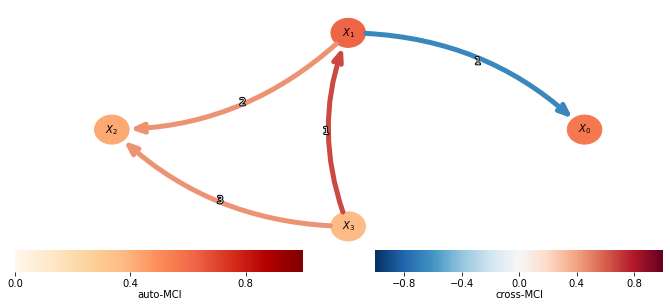

In [31]:
link_matrix = pcmci.return_significant_links(
    pq_matrix=q_matrix,
    val_matrix=results['val_matrix'],
    alpha_level=0.01
)['link_matrix']
ti_plt.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    figsize=(10, 5),
)

(<Figure size 720x360 with 2 Axes>, <AxesSubplot:>)

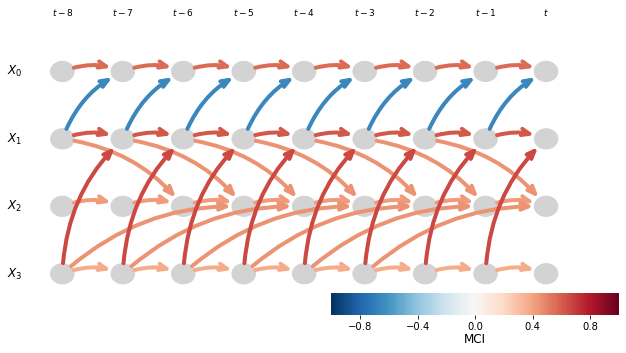

In [33]:
ti_plt.plot_time_series_graph(
    figsize=(10, 5),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
)